# Evaluating Dynamic Sea Level along the Dutch coast in an Earth System Model

There is one main folder `thesis`, which includes the following subfolders and relevant files:
```
-code    
-data
    -zos_denhelder
        ->zos_DenHelder.nc
    -> zos_hoek1.nc (this file will be created by selecting the location in the Delfzijl notebook)
    -> zos_delf1.nc (same)
    -> zos_NorthSea_HR.nc 
    -> zos_NorthSea_SR.nc
    -> zos_NorthSea_SR_regridded.nc
-results
```

In [29]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
import numpy as np
import scipy as scipy
from scipy import signal
import matplotlib
rng = np.random.default_rng()
import cartopy.crs as ccrs

## The `zos` time series at Den Helder and global mean `zos`

In [2]:
# Now we define dates and months for the period used
dates = pd.date_range(start='1865-01-01', end='2021-01-01', freq='M') 

### Reading data

First, we open de model data and tide gauge observations and convert them to xarray. 

In [3]:
# First we open the downloaded EC-Earth3p model data
df = xr.open_dataarray('../data/zos_denhelder/zos_DenHelder.nc')
df

<xarray.DataArray (time: 1812, src: 2, exp: 2, member: 3)>
array([[[[-0.383607, ..., -0.128381],
         [-0.280609, ..., -0.384627]],

        [[-0.204909, ..., -0.245206],
         [-0.226851, ...,  0.056227]]],


       ...,


       [[[      nan, ...,       nan],
         [      nan, ...,       nan]],

        [[      nan, ...,       nan],
         [      nan, ...,       nan]]]])
Coordinates:
  * time     (time) datetime64[ns] 1950-01-31 1950-02-28 ... 2100-12-31
  * src      (src) object 'EC-Earth3P' 'EC-Earth3P-HR'
  * exp      (exp) object 'control' 'hist+future'
  * member   (member) object 'r1i1p2f1' 'r2i1p2f1' 'r3i1p2f1'

In [4]:
gmzos = xr.open_dataarray('../data/gmzos_2exps.nc')
gmzos

<xarray.DataArray (time: 1812, src: 2, exp: 2, member: 3)>
array([[[[-0.075528, ..., -0.071267],
         [-0.075127, ..., -0.075474]],

        [[-0.009733, ..., -0.032954],
         [-0.009632, ..., -0.032877]]],


       ...,


       [[[      nan, ...,       nan],
         [      nan, ...,       nan]],

        [[      nan, ...,       nan],
         [      nan, ...,       nan]]]])
Coordinates:
  * time     (time) datetime64[ns] 1950-01-31 1950-02-28 ... 2100-12-31
  * src      (src) object 'EC-Earth3P' 'EC-Earth3P-HR'
  * exp      (exp) object 'control' 'hist+future'
  * member   (member) object 'r1i1p2f1' 'r2i1p2f1' 'r3i1p2f1'

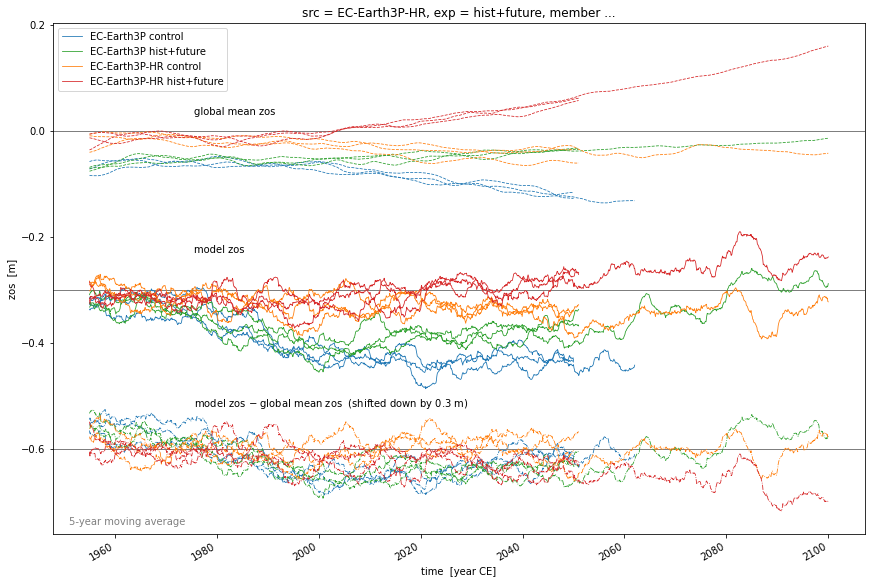

In [25]:
plt.figure(figsize=(12,8), constrained_layout=True)
plt.axhline(0, c='k', lw=.5)
plt.axhline(-.3, c='k', lw=.5)
plt.axhline(-.6, c='k', lw=.5)
for i, src in enumerate(df.src.values):
    for j, exp in enumerate(df.exp.values):
        for k, mem in enumerate(df.member.values):
            if k==0: label = f'{src} {exp}'
            else:    label = None
            c = f'C{i+2*j}'
            df           .sel(src=src, exp=exp, member=mem).rolling(time=5*12).mean().plot(c=c, lw=.8, label=label)
            gmzos        .sel(src=src, exp=exp, member=mem).rolling(time=5*12).mean().plot(c=c, lw=.8, ls='--')
            (df-gmzos-.3).sel(src=src, exp=exp, member=mem).rolling(time=5*12).mean().plot(c=c, lw=.8, ls='-.')
plt.legend()

plt.text(2020, .03, 'global mean zos')
plt.text(2020, -.23, 'model zos')
plt.text(2020, -.52, r'model zos $-$ global mean zos  (shifted down by 0.3 m)')
plt.text(0.02, 0.02, '5-year moving average', color='grey',  transform=plt.gca().transAxes)
plt.xlabel('time  [year CE]')
plt.ylabel('zos  [m]')

plt.savefig('../results/gmzos_effect')


In [6]:
df = df - gmzos

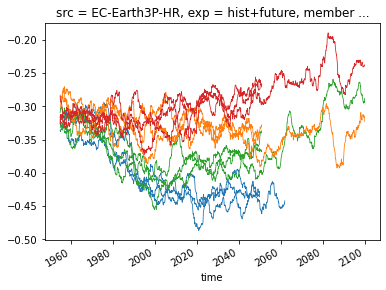

In [21]:
for i, src in enumerate(df.src.values):
    for j, exp in enumerate(df.exp.values):
        for k, mem in enumerate(df.member.values):
            if k==0: label = f'{src} {exp}'
            else:    label = None
            c = f'C{i+2*j}'
            df           .sel(src=src, exp=exp, member=mem).rolling(time=5*12).mean().plot(c=c, lw=.8, label=label)

### Model `zos`

First, we plot the model data for the location. EC-Earth3p
uses two configurations, the HR with an eddy-permitting ocean (0.25° grid spacing in the ocean) and the SR
with a non-eddying ocean (1° ocean grid spacing). For this paper, we will use local data of a point closest to
the observational data we have. I will start with a single location, which is Den Helder. I imported ’zos’ data
for the DSL. I will also detrend the data below and show the average of all ensemble members, to create one nice figure with two subplots for a good overview.

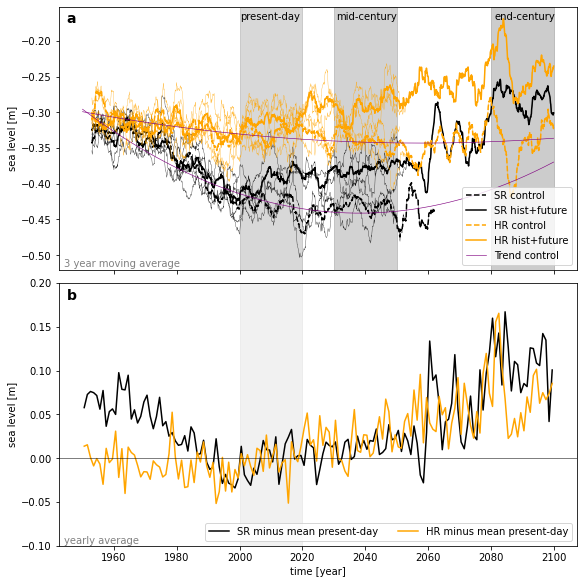

In [60]:
f, ax = plt.subplots(2,1, figsize=(8,8), sharex=True, constrained_layout=True)
f.align_ylabels()

# In the first figure we plot all model data; SR and HR control and hist+future over the whole time series for the three members
#for i, Src in enumerate(df.src.values): # Src is SR and HR
    # In b), we will also plot the hist+future minus the mean of present-day (hist)

hf = df.sel(exp='hist+future').mean('member')
presentday = hf.sel(time=slice('2000-01-31', '2020-12-31'))
timevalues = df.time.dt.year + df.time.dt.month/12 # We want the means per year

psds = presentday.sel(src='EC-Earth3P')
hists = hf.sel(src='EC-Earth3P') - psds.mean()

psdh = presentday.sel(src='EC-Earth3P-HR')
histh = hf.sel(src='EC-Earth3P-HR') - psdh.mean()
histh.time.dt.year

ax[1].plot(timevalues.groupby(df.time.dt.year).mean(), hists.groupby(histh.time.dt.year).mean(), 
            label=f'SR minus mean present-day', color='black')


ax[1].plot(timevalues.groupby(df.time.dt.year).mean(), histh.groupby(histh.time.dt.year).mean(), 
            label=f'HR minus mean present-day', color='orange')

for i, Src in enumerate(df.src.values): # Src is SR and HR    
    for j, Exp in enumerate(df.exp.values): # Exp are the two runs        
        # Now, we create the actual plot for this using a three year rolling average to make it clearer
        
        # First plot the time series for the average of all members
        ax[0].plot(timevalues, df.mean('member').sel({'exp':Exp, 'src':Src}).rolling(time=36).mean(), 
                   label=f'{["SR","HR"][i]} {Exp}', color=['black','orange'][i], ls=['--','-'][j])
       
        # Then all the members seperately, too
        for mem in df.member.values:
            ax[0].plot(timevalues, df.sel({'member':mem, 'exp':Exp, 'src':Src}).rolling(time=36).mean(),
                       color=['black','orange'][i], lw=.3)
            
# We start with selecting the control run data for SR
dc =df.mean('member').sel(exp='control').sel(src='EC-Earth3P').groupby(df.time.dt.year).mean()
# Then we do the second degree fitting for the control run 
fit1 = dc.polyfit(dim='year', deg=2).polyfit_coefficients 
# So then below is the curve for the trend in the control run
ts1 = dc.year**2*fit1[0] + dc.year*fit1[1]+fit1[2] 
ax[0].plot(ts1.year, ts1, label = f'Trend control', color='purple', lw=0.6)

# Then we do exactly the same for HR
dch=df.mean('member').sel(exp='control').sel(src='EC-Earth3P-HR').groupby(df.time.dt.year).mean()
fit2 = dch.polyfit(dim='year', deg=2).polyfit_coefficients 
ts2 = dch.year**2*fit2[0] + dch.year*fit2[1]+fit2[2] 
ax[0].plot(ts2.year, ts2, color='purple', lw=0.6)
    
# Then we set the layout for the first figure
ax[0].set_ylabel('sea level [m]')
ax[0].text(.01,.01, '3 year moving average', color='grey', transform=ax[0].transAxes)
ax[0].text(.015,.98, 'a', transform=ax[0].transAxes, va='top', ha='left', weight='bold', fontsize=14, color='black')

# Here we create three grey boxes to show the different time spans we will refer to further on
ax[0].axvspan(2000,2020, color='grey', alpha=.3) 
ax[0].text(.35,.98, 'present-day', transform=ax[0].transAxes, va='top', fontsize=10, color='black')
ax[0].axvspan(2030,2050, color='grey', alpha=.35)
ax[0].text(.535,.98, 'mid-century', transform=ax[0].transAxes, va='top', fontsize=10, color='black')
ax[0].axvspan(2080,2100, color='grey', alpha=.4)
ax[0].text(.84,.98, 'end-century', transform=ax[0].transAxes, va='top', fontsize=10, color='black')
ax[0].legend(ncol=1, loc=4)

# Now we create the layout for the second figure
ax[1].axhline(0, c='k', lw=.5)
ax[1].axvspan(2000,2020, color='lightgrey', alpha=.3) 
ax[1].set_ylabel('sea level [m]')
ax[1].set_ylim((-0.1, 0.2))
ax[1].set_xlabel('time [year]')
ax[1].text(.01,.01, 'yearly average', color='grey', transform=ax[1].transAxes)
ax[1].legend(ncol=2, loc=4)
ax[1].text(.015,.98, 'b', transform=ax[1].transAxes, va='top', ha='left', weight='bold', fontsize=14, color='black')

# Lastly, we save the figure
f.savefig('../results/modelseries.jpg', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'DSL change [m]')

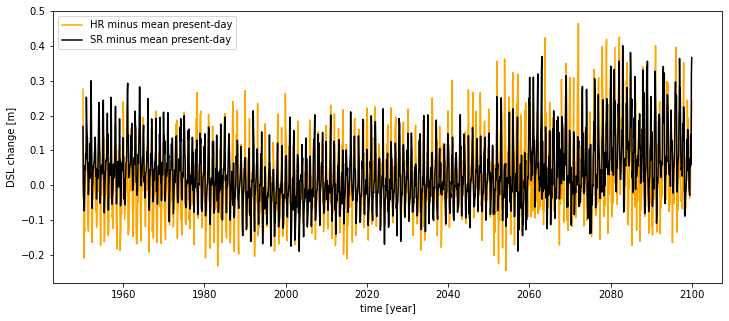

In [8]:
fig = plt.figure(figsize=(12,5))
hf = df.sel(exp='hist+future').mean('member')
presentday = hf.sel(time=slice('2000-01-31', '2020-12-31'))

psds = presentday.sel(src='EC-Earth3P')
hists = hf.sel(src='EC-Earth3P') - psds.mean()

psdh = presentday.sel(src='EC-Earth3P-HR')
histh = hf.sel(src='EC-Earth3P-HR') - psdh.mean()

plt.plot(df.time, histh, 
            label=f'HR minus mean present-day', color='orange')

plt.plot(df.time, hists, 
            label=f'SR minus mean present-day', color='black')

plt.xlabel('time [year]')
plt.legend()
plt.ylabel('DSL change [m]')
#fig.savefig('../results/extremes.jpg', dpi=300, bbox_inches='tight')

## Maps North Sea overview

### DSL `zos` historic+future run

In [9]:
dar = xr.open_dataarray(f'../data/regridded/zos_NorthSea_SR_regridded.nc')
dah = xr.open_dataarray(f'../data/zos_NorthSea_HR.nc')

In [10]:
# remove global mean
gmzos = xr.open_dataarray('../data/gmzos_2exps.nc')

dar = dar.load() - gmzos.sel(src='EC-Earth3P')
dah = dah.load() - gmzos.sel(src='EC-Earth3P-HR')

In [11]:
difference_map = dah - dar
difference_map.load().to_netcdf('../data/zos_NorthSea_HR-SR.nc')

### ensemble mean

-0.4649388
-0.4612730201411095
HR -0.45628238125204384
0 0 1.7298666725748027e-17
0 1 0.023169891741776562
0 2 0.06187788901346038
-0.5691419
-0.5051062910260544
SR -0.5115479922068609
1 0 -1.0118488325697629e-16
1 1 0.02878887162917385
1 2 0.10992152578187878
HR-SR 0.058667304122710276
2 0 0.0
2 1 -0.006527162918400283
2 2 -0.04983234639280041


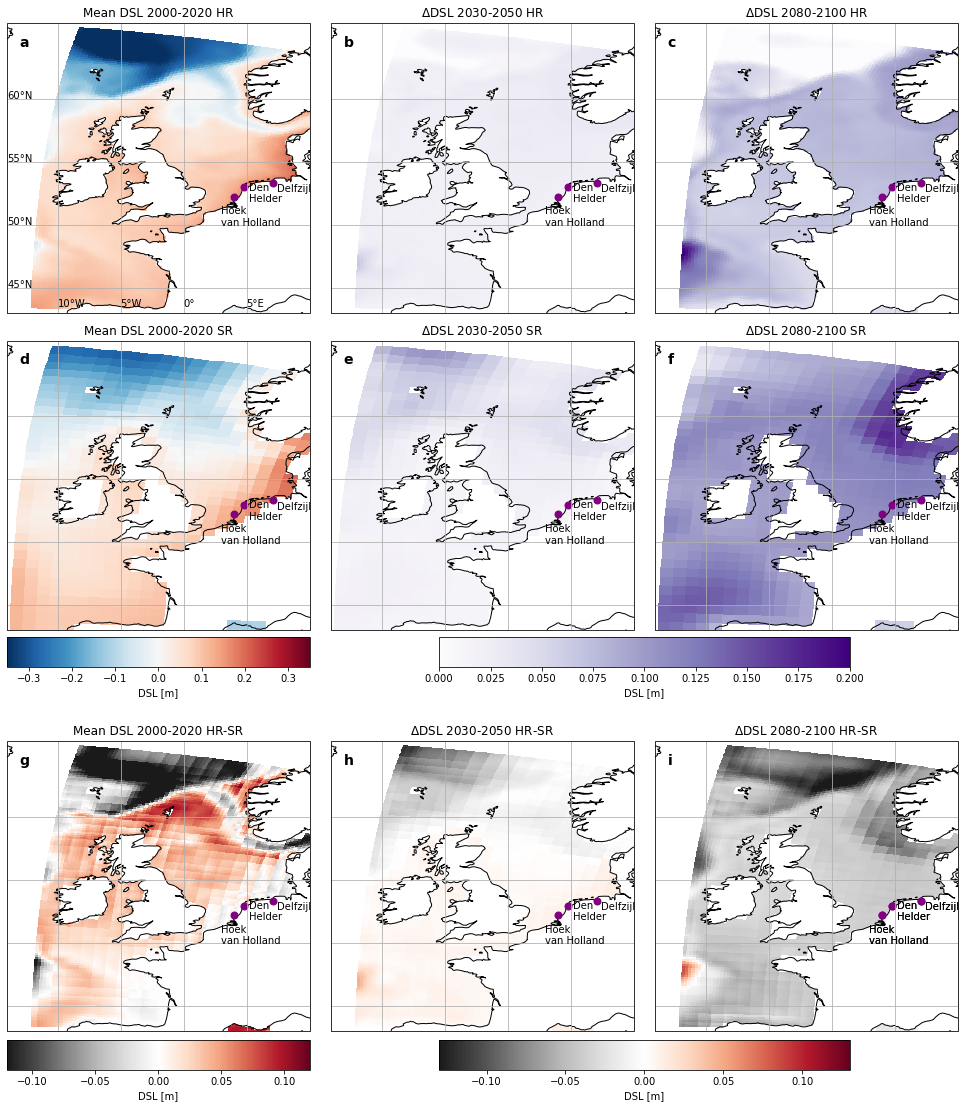

In [52]:
f = plt.figure(figsize=(15,10.5))

for i, res in enumerate(['HR','SR', 'HR-SR']):
    da = xr.open_dataarray(f'../data/zos_NorthSea_{res}.nc')
    if i<2:  # removing global mean from HR and SR; HR-SR is already done above
        print(da.mean().values)
        da = da - gmzos.sel(src=['EC-Earth3P-HR','EC-Earth3P'][i])
        print(da.mean().values)
    # member average
    da = da.mean('member')
    # monthly -> yearly
    da = da.groupby(da.time.dt.year).mean()
    # rename longitudes
    da = da.assign_coords(longitude=(((da.longitude + 180) % 360) - 180))
    dhf = da.sel(exp='hist+future')

    # final fields
    # print(dhf)
    hist = dhf.isel({'year':slice( 50, 70)}).mean('year')  # 2000-2020
    midc = dhf.isel({'year':slice( 80,100)}).mean('year')  # 2030-2050
    endc = dhf.isel({'year':slice(130,150)}).mean('year')  # 2080-2100
    
    hist_ = hist - hist.mean()  # 2000-2020
    print(res, hist.mean().values)
    
    for j in range(3):
        # mark Den Helder
       
        delta = r'$\Delta$'

        # we still need to select the mean of a time to show in the map:
        #here first the first maps, which are Mean DSL 90-20 hist+future
        if j==0:
            field = hist_
           
            if i==0:
                title = f'Mean DSL 2000-2020 {res}'
                ax = f.add_axes([.1+j*.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                ax.text(-13, 65, 'a', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.PlateCarree())
                cmap = 'RdBu_r'
                minv, maxv = -.35, .35
                ax.text(0, 43.5, '0°', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(5, 43.5, '5°E', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-5, 43.5, '5°W', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-10, 43.5, '10°W', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-14, 60, '60°N', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-14, 55, '55°N', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-14, 50, '50°N', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(-14, 45, '45°N', fontsize=10, transform=ccrs.PlateCarree())

            
            if i==1:
                title = f'Mean DSL 2000-2020 {res}'
                ax = f.add_axes([.1+j*.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                ax.text(-13, 65, 'd', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.PlateCarree())
                cmap = 'RdBu_r'
                minv, maxv = -.35, .35
                
            if i==2:
                title = f'Mean DSL 2000-2020 {res}'
                ax = f.add_axes([.1+j*.3,.55-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdGy_r'
                minv, maxv = -.12, .12
                ax.text(-13, 65, 'g', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.PlateCarree())
            
           
        #then the second, which is the change 2030-2050 with regard to mean DSL 90-20 hist+future
        elif j==1:
            title = f'{delta}DSL 2030-2050 {res}'
            field = midc - hist
            
            if i==0:
                ax = f.add_axes([.1+.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .2
                ax.text(-13, 65, 'b', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.PlateCarree())
            if i==1:
                ax = f.add_axes([.1+.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .2
                ax.text(-13, 65, 'e', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.PlateCarree())
            if i==2:
                ax = f.add_axes([.1+.3,.55-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdGy_r'
                minv, maxv = -.13, .13
                ax.text(-13, 65, 'h', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.PlateCarree())    
       
        #then the third, which is the change 2080-2100 with regard to mean DSL 90-20 hist+future
        elif j==2:
            title = f'{delta}DSL 2080-2100 {res}'
            field = endc - hist
            
            if i==0:
                ax = f.add_axes([.1+j*.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .2
                ax.text(-13, 65, 'c', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.PlateCarree())
            elif i==1:
                ax = f.add_axes([.1+j*.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .2
                ax.text(-13, 65, 'f', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.PlateCarree())
            elif i==2:
                ax = f.add_axes([.1+j*.3,.55-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdGy_r'
                minv, maxv = -0.13, .13
                ax.text(-13, 65, 'i', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.PlateCarree())
                ax.plot(4.7607972, 52.9562808, 'o', markersize=7, color='purple', transform=ccrs.PlateCarree())
                ax.plot(4, 52.2, 'o', markersize=7, color='purple', transform=ccrs.PlateCarree())
                ax.plot(7.1,53.33, 'o', markersize=7, color='purple', transform=ccrs.PlateCarree())
                ax.text(5.2, 51.8, 'Den\nHelder', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(3,49.9, 'Hoek\nvan Holland', fontsize=10, transform=ccrs.PlateCarree())
                ax.text(7.4, 52.6, 'Delfzijl', fontsize=10, transform=ccrs.PlateCarree())
                
        ax.set_extent([-14,10,43,66], crs=ccrs.PlateCarree())
        ax.plot(4.76, 52.95, 'o', markersize=7, color='purple', transform=ccrs.PlateCarree())
        ax.plot(4, 52.2, 'o', markersize=7, color='purple', transform=ccrs.PlateCarree())
        ax.plot(7.1,53.33, 'o', markersize=7, color='purple', transform=ccrs.PlateCarree())
        ax.text(5.2, 51.8, 'Den\nHelder', fontsize=10, transform=ccrs.PlateCarree())
        ax.text(3,49.9, 'Hoek\nvan Holland', fontsize=10, transform=ccrs.PlateCarree())
        ax.text(7.4, 52.6, 'Delfzijl', fontsize=10, transform=ccrs.PlateCarree())

        print(i,j, field.mean().values)

        im = ax.pcolormesh(da.longitude, da.latitude, 
                            field,
                            vmin=minv, vmax=maxv, cmap=cmap,
                            transform=ccrs.PlateCarree())
        ax.set_title(title)
        ax.coastlines()
        gl = ax.gridlines()
        gl.xlocator = mticker.FixedLocator(np.arange(-15,10,5))
        gl.ylocator = mticker.FixedLocator(np.arange(45,65,5))
        
        if i==1:
            if j==0:
                cax = f.add_axes([.1+j*.3,0.12,.28,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
            elif j==2:
                cax = f.add_axes([.5,0.12,.38,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
        
        if i==2:
            if j==0:
                cax = f.add_axes([.1+j*.3,-0.413,.28,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
            elif j==2:
                cax = f.add_axes([.5,-0.413,.38,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
plt.savefig('../results/hist+futzosmap.jpg', dpi=300, bbox_inches='tight')

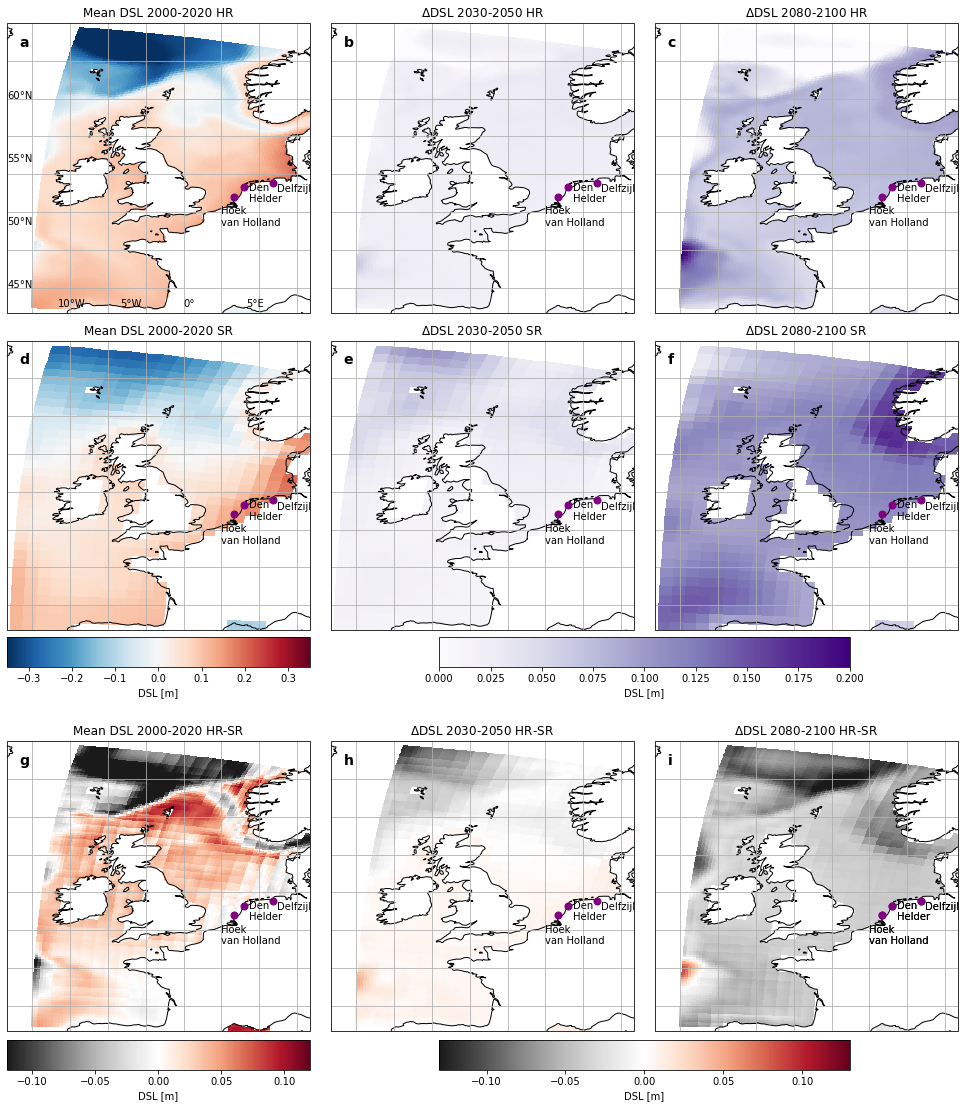

In [ ]:
f = plt.figure(figsize=(15,10.5))

for i, res in enumerate(['HR','SR', 'HR-SR']):
    da = xr.open_dataarray(f'../data/zos_NorthSea_{res}.nc')
    if i<2:  # removing global mean from HR and SR; HR-SR is already done above
        da = da - gmzos.sel(src=['EC-Earth3P-HR','EC-Earth3P'][i])
    # member average
    da = da.mean('member')
    # monthly -> yearly
    da = da.groupby(da.time.dt.year).mean()
    # rename longitudes
    da = da.assign_coords(longitude=(((da.longitude + 180) % 360) - 180))
    dhf = da.sel(exp='hist+future')

    # final fields
    hist = dhf.isel({'year':slice( 50, 70)}).mean('year')  # 2000-2020
    midc = dhf.isel({'year':slice( 80,100)}).mean('year')  # 2030-2050
    endc = dhf.isel({'year':slice(130,150)}).mean('year')  # 2080-2100
    
    hist_ = hist - hist.mean()  # 2000-2020
    
    
    for j in range(3):
        # mark Den Helder
       
        delta = r'$\Delta$'

        # we still need to select the mean of a time to show in the map:
        #here first the first maps, which are Mean DSL 90-20 hist+future
        if j==0:
            field = hist_
           
            if i==0:
                title = f'Mean DSL 2000-2020 {res}'
                ax = f.add_axes([.1+j*.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                ax.text(-13, 65, 'a', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
                cmap = 'RdBu_r'
                minv, maxv = -.35, .35
                ax.text(0, 43.5, '0°', fontsize=10, transform=ccrs.Geodetic())
                ax.text(5, 43.5, '5°E', fontsize=10, transform=ccrs.Geodetic())
                ax.text(-5, 43.5, '5°W', fontsize=10, transform=ccrs.Geodetic())
                ax.text(-10, 43.5, '10°W', fontsize=10, transform=ccrs.Geodetic())
                ax.text(-14, 60, '60°N', fontsize=10, transform=ccrs.Geodetic())
                ax.text(-14, 55, '55°N', fontsize=10, transform=ccrs.Geodetic())
                ax.text(-14, 50, '50°N', fontsize=10, transform=ccrs.Geodetic())
                ax.text(-14, 45, '45°N', fontsize=10, transform=ccrs.Geodetic())

            
            if i==1:
                title = f'Mean DSL 2000-2020 {res}'
                ax = f.add_axes([.1+j*.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                ax.text(-13, 65, 'd', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
                cmap = 'RdBu_r'
                minv, maxv = -.35, .35
                
            if i==2:
                title = f'Mean DSL 2000-2020 {res}'
                ax = f.add_axes([.1+j*.3,.55-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdGy_r'
                minv, maxv = -.12, .12
                ax.text(-13, 65, 'g', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            
           
        #then the second, which is the change 2030-2050 with regard to mean DSL 90-20 hist+future
        elif j==1:
            title = f'{delta}DSL 2030-2050 {res}'
            field = midc - hist
            
            if i==0:
                ax = f.add_axes([.1+.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .2
                ax.text(-13, 65, 'b', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            if i==1:
                ax = f.add_axes([.1+.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .2
                ax.text(-13, 65, 'e', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            if i==2:
                ax = f.add_axes([.1+.3,.55-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdGy_r'
                minv, maxv = -.13, .13
                ax.text(-13, 65, 'h', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())    
       
        #then the third, which is the change 2080-2100 with regard to mean DSL 90-20 hist+future
        elif j==2:
            title = f'{delta}DSL 2080-2100 {res}'
            field = endc - hist
            
            if i==0:
                ax = f.add_axes([.1+j*.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .2
                ax.text(-13, 65, 'c', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            elif i==1:
                ax = f.add_axes([.1+j*.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .2
                ax.text(-13, 65, 'f', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            elif i==2:
                ax = f.add_axes([.1+j*.3,.55-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdGy_r'
                minv, maxv = -0.13, .13
                ax.text(-13, 65, 'i', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
                ax.plot(4.7607972, 52.9562808, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
                ax.plot(4, 52.2, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
                ax.plot(7.1,53.33, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
                ax.text(5.2, 51.8, 'Den\nHelder', fontsize=10, transform=ccrs.Geodetic())
                ax.text(3,49.9, 'Hoek\nvan Holland', fontsize=10, transform=ccrs.Geodetic())
                ax.text(7.4, 52.6, 'Delfzijl', fontsize=10, transform=ccrs.Geodetic())
                
        ax.set_extent([-14,10,43,66], crs=ccrs.PlateCarree())
        ax.plot(4.76, 52.95, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
        ax.plot(4, 52.2, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
        ax.plot(7.1,53.33, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
        ax.text(5.2, 51.8, 'Den\nHelder', fontsize=10, transform=ccrs.Geodetic())
        ax.text(3,49.9, 'Hoek\nvan Holland', fontsize=10, transform=ccrs.Geodetic())
        ax.text(7.4, 52.6, 'Delfzijl', fontsize=10, transform=ccrs.Geodetic())
        im = ax.pcolormesh(da.longitude, da.latitude, 
                            field,
                            vmin=minv, vmax=maxv, cmap=cmap,
                            transform=ccrs.PlateCarree())
        ax.set_title(title)
        ax.coastlines()
        ax.gridlines()
        
        if i==1:
            if j==0:
                cax = f.add_axes([.1+j*.3,0.12,.28,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
            elif j==2:
                cax = f.add_axes([.5,0.12,.38,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
        
        if i==2:
            if j==0:
                cax = f.add_axes([.1+j*.3,-0.413,.28,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
            elif j==2:
                cax = f.add_axes([.5,-0.413,.38,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
plt.savefig('../results/hist+futzosmap.jpg', dpi=300, bbox_inches='tight')

### Member 1:

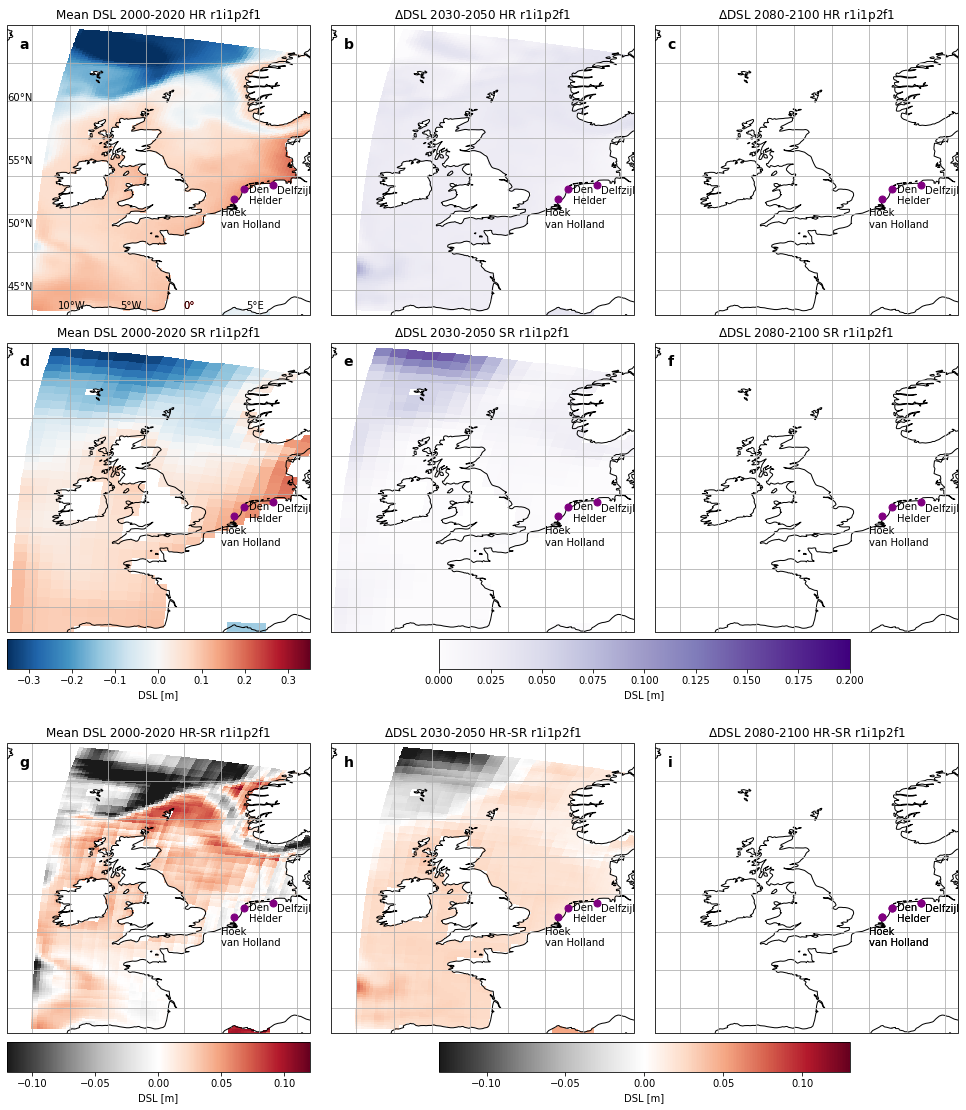

In [26]:
f = plt.figure(figsize=(15,10.5))

for i, res in enumerate(['HR','SR', 'HR-SR']):
    da = xr.open_dataarray(f'../data/zos_NorthSea_{res}.nc')
    if i<2:  # removing global mean from HR and SR; HR-SR is already done above
        da = da - gmzos.sel(src=['EC-Earth3P-HR','EC-Earth3P'][i])
    # member average
    da = da.sel(member='r1i1p2f1')
    # monthly -> yearly
    da = da.groupby(da.time.dt.year).mean()
    # rename longitudes
    da = da.assign_coords(longitude=(((da.longitude + 180) % 360) - 180))
    dhf = da.sel(exp='hist+future')

    # final fields
    hist = dhf.isel({'year':slice( 50, 70)}).mean('year')  # 2000-2020
    midc = dhf.isel({'year':slice( 80,100)}).mean('year')  # 2030-2050
    endc = dhf.isel({'year':slice(130,150)}).mean('year')  # 2080-2100
    
    hist_ = hist - hist.mean()  # 2000-2020
    
    
    for j in range(3):
        # mark Den Helder
       
        delta = r'$\Delta$'

        # we still need to select the mean of a time to show in the map:
        #here first the first maps, which are Mean DSL 90-20 hist+future
        if j==0:
            field = hist_
           
            if i==0:
                title = f'Mean DSL 2000-2020 {res} r1i1p2f1'
                ax = f.add_axes([.1+j*.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                ax.text(-13, 65, 'a', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
                cmap = 'RdBu_r'
                minv, maxv = -.35, .35
                ax.text(0, 43.5, '0°', fontsize=10, color='red', transform=ccrs.PlateCarree())
                ax.text(0, 43.5, '0°', fontsize=10, transform=ccrs.Geodetic())
                ax.text(5, 43.5, '5°E', fontsize=10, transform=ccrs.Geodetic())
                ax.text(-5, 43.5, '5°W', fontsize=10, transform=ccrs.Geodetic())
                ax.text(-10, 43.5, '10°W', fontsize=10, transform=ccrs.Geodetic())
                ax.text(-14, 60, '60°N', fontsize=10, transform=ccrs.Geodetic())
                ax.text(-14, 55, '55°N', fontsize=10, transform=ccrs.Geodetic())
                ax.text(-14, 50, '50°N', fontsize=10, transform=ccrs.Geodetic())
                ax.text(-14, 45, '45°N', fontsize=10, transform=ccrs.Geodetic())
               
            if i==1:
                title = f'Mean DSL 2000-2020 {res} r1i1p2f1'
                ax = f.add_axes([.1+j*.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                ax.text(-13, 65, 'd', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
                cmap = 'RdBu_r'
                minv, maxv = -.35, .35
                
            if i==2:
                title = f'Mean DSL 2000-2020 {res} r1i1p2f1'
                ax = f.add_axes([.1+j*.3,.55-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdGy_r'
                minv, maxv = -.12, .12
                ax.text(-13, 65, 'g', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            
           
        #then the second, which is the change 2030-2050 with regard to mean DSL 90-20 hist+future
        elif j==1:
            title = f'{delta}DSL 2030-2050 {res} r1i1p2f1'
            field = midc - hist
            
            if i==0:
                ax = f.add_axes([.1+.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .2
                ax.text(-13, 65, 'b', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            if i==1:
                ax = f.add_axes([.1+.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .2
                ax.text(-13, 65, 'e', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            if i==2:
                ax = f.add_axes([.1+.3,.55-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdGy_r'
                minv, maxv = -.13, .13
                ax.text(-13, 65, 'h', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())    
       
        #then the third, which is the change 2080-2100 with regard to mean DSL 90-20 hist+future
        elif j==2:
            title = f'{delta}DSL 2080-2100 {res} r1i1p2f1'
            field = endc - hist
            
            if i==0:
                ax = f.add_axes([.1+j*.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .2
                ax.text(-13, 65, 'c', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            elif i==1:
                ax = f.add_axes([.1+j*.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .2
                ax.text(-13, 65, 'f', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            elif i==2:
                ax = f.add_axes([.1+j*.3,.55-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdGy_r'
                minv, maxv = -0.13, .13
                ax.text(-13, 65, 'i', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
                ax.plot(4.7607972, 52.9562808, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
                ax.plot(4, 52.2, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
                ax.plot(7.1,53.33, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
                ax.text(5.2, 51.8, 'Den\nHelder', fontsize=10, transform=ccrs.Geodetic())
                ax.text(3,49.9, 'Hoek\nvan Holland', fontsize=10, transform=ccrs.Geodetic())
                ax.text(7.4, 52.6, 'Delfzijl', fontsize=10, transform=ccrs.Geodetic())
                
        ax.set_extent([-14,10,43,66], crs=ccrs.PlateCarree())
        ax.plot(4.76, 52.95, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
        ax.plot(4, 52.2, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
        ax.plot(7.1,53.33, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
        ax.text(5.2, 51.8, 'Den\nHelder', fontsize=10, transform=ccrs.Geodetic())
        ax.text(3,49.9, 'Hoek\nvan Holland', fontsize=10, transform=ccrs.Geodetic())
        ax.text(7.4, 52.6, 'Delfzijl', fontsize=10, transform=ccrs.Geodetic())
        im = ax.pcolormesh(da.longitude, da.latitude, 
                            field,
                            vmin=minv, vmax=maxv, cmap=cmap,
                            transform=ccrs.PlateCarree())
        ax.set_title(title)
        ax.coastlines()
        ax.gridlines()
        
        if i==1:
            if j==0:
                cax = f.add_axes([.1+j*.3,0.12,.28,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
            elif j==2:
                cax = f.add_axes([.5,0.12,.38,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
        
        if i==2:
            if j==0:
                cax = f.add_axes([.1+j*.3,-0.413,.28,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
            elif j==2:
                cax = f.add_axes([.5,-0.413,.38,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
plt.savefig('../results/hist+futzosmap1.jpg', dpi=300, bbox_inches='tight')

### Member 2:

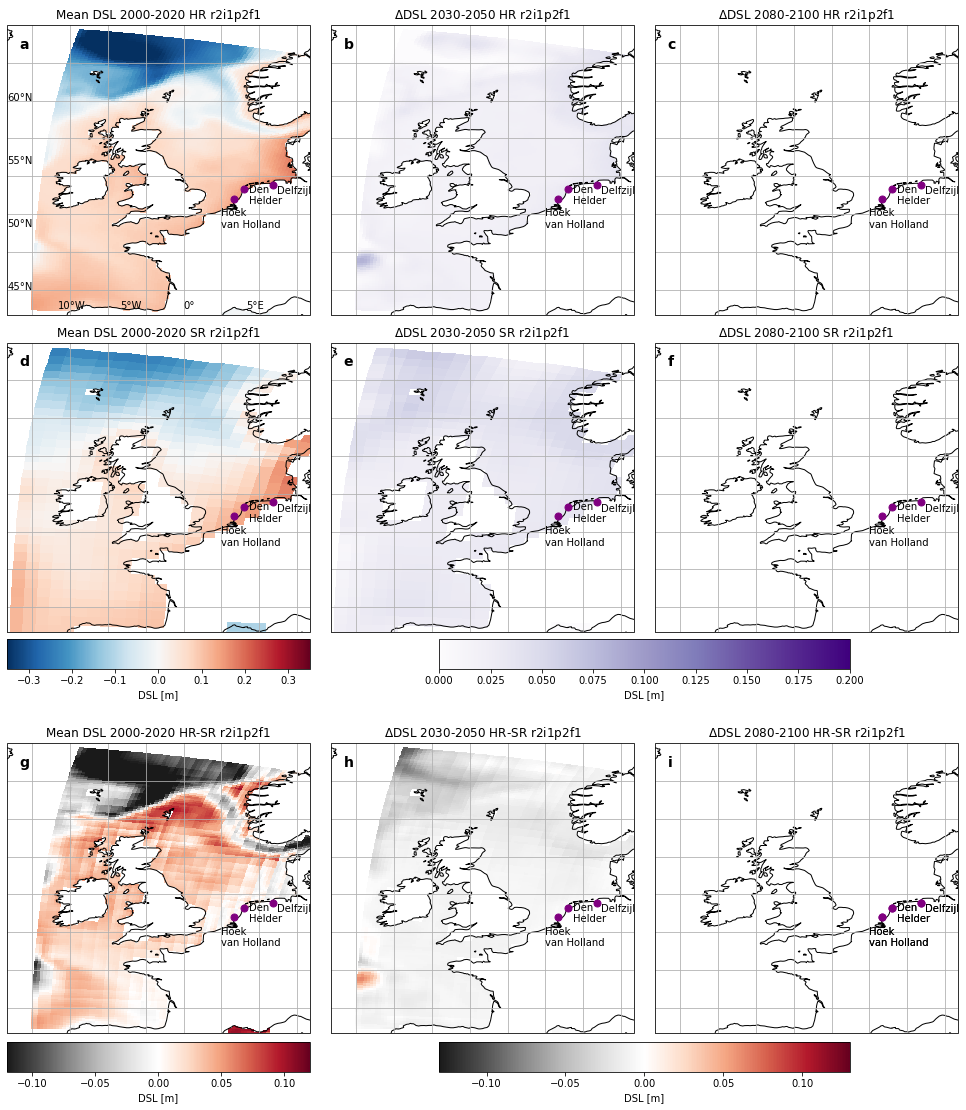

In [18]:
f = plt.figure(figsize=(15,10.5))

for i, res in enumerate(['HR','SR', 'HR-SR']):
    da = xr.open_dataarray(f'../data/zos_NorthSea_{res}.nc')
    if i<2:  # removing global mean from HR and SR; HR-SR is already done above
        da = da - gmzos.sel(src=['EC-Earth3P-HR','EC-Earth3P'][i])
    # member average
    da = da.sel(member='r2i1p2f1')
    # monthly -> yearly
    da = da.groupby(da.time.dt.year).mean()
    # rename longitudes
    da = da.assign_coords(longitude=(((da.longitude + 180) % 360) - 180))
    dhf = da.sel(exp='hist+future')

    # final fields
    hist = dhf.isel({'year':slice( 50, 70)}).mean('year')  # 2000-2020
    midc = dhf.isel({'year':slice( 80,100)}).mean('year')  # 2030-2050
    endc = dhf.isel({'year':slice(130,150)}).mean('year')  # 2080-2100
    
    hist_ = hist - hist.mean()  # 2000-2020
    
    
    for j in range(3):
        # mark Den Helder
       
        delta = r'$\Delta$'

        # we still need to select the mean of a time to show in the map:
        #here first the first maps, which are Mean DSL 90-20 hist+future
        if j==0:
            field = hist_
           
            if i==0:
                title = f'Mean DSL 2000-2020 {res} r2i1p2f1'
                ax = f.add_axes([.1+j*.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                ax.text(-13, 65, 'a', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
                cmap = 'RdBu_r'
                minv, maxv = -.35, .35
                ax.text(0, 43.5, '0°', fontsize=10, transform=ccrs.Geodetic())
                ax.text(5, 43.5, '5°E', fontsize=10, transform=ccrs.Geodetic())
                ax.text(-5, 43.5, '5°W', fontsize=10, transform=ccrs.Geodetic())
                ax.text(-10, 43.5, '10°W', fontsize=10, transform=ccrs.Geodetic())
                ax.text(-14, 60, '60°N', fontsize=10, transform=ccrs.Geodetic())
                ax.text(-14, 55, '55°N', fontsize=10, transform=ccrs.Geodetic())
                ax.text(-14, 50, '50°N', fontsize=10, transform=ccrs.Geodetic())
                ax.text(-14, 45, '45°N', fontsize=10, transform=ccrs.Geodetic())
               
            if i==1:
                title = f'Mean DSL 2000-2020 {res} r2i1p2f1'
                ax = f.add_axes([.1+j*.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                ax.text(-13, 65, 'd', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
                cmap = 'RdBu_r'
                minv, maxv = -.35, .35
                
            if i==2:
                title = f'Mean DSL 2000-2020 {res} r2i1p2f1'
                ax = f.add_axes([.1+j*.3,.55-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdGy_r'
                minv, maxv = -.12, .12
                ax.text(-13, 65, 'g', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            
           
        #then the second, which is the change 2030-2050 with regard to mean DSL 90-20 hist+future
        elif j==1:
            title = f'{delta}DSL 2030-2050 {res} r2i1p2f1'
            field = midc - hist
            
            if i==0:
                ax = f.add_axes([.1+.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .2
                ax.text(-13, 65, 'b', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            if i==1:
                ax = f.add_axes([.1+.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .2
                ax.text(-13, 65, 'e', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            if i==2:
                ax = f.add_axes([.1+.3,.55-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdGy_r'
                minv, maxv = -.13, .13
                ax.text(-13, 65, 'h', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())    
       
        #then the third, which is the change 2080-2100 with regard to mean DSL 90-20 hist+future
        elif j==2:
            title = f'{delta}DSL 2080-2100 {res} r2i1p2f1'
            field = endc - hist
            
            if i==0:
                ax = f.add_axes([.1+j*.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .2
                ax.text(-13, 65, 'c', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            elif i==1:
                ax = f.add_axes([.1+j*.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .2
                ax.text(-13, 65, 'f', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            elif i==2:
                ax = f.add_axes([.1+j*.3,.55-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdGy_r'
                minv, maxv = -0.13, .13
                ax.text(-13, 65, 'i', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
                ax.plot(4.7607972, 52.9562808, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
                ax.plot(4, 52.2, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
                ax.plot(7.1,53.33, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
                ax.text(5.2, 51.8, 'Den\nHelder', fontsize=10, transform=ccrs.Geodetic())
                ax.text(3,49.9, 'Hoek\nvan Holland', fontsize=10, transform=ccrs.Geodetic())
                ax.text(7.4, 52.6, 'Delfzijl', fontsize=10, transform=ccrs.Geodetic())
                
        ax.set_extent([-14,10,43,66], crs=ccrs.PlateCarree())
        ax.plot(4.76, 52.95, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
        ax.plot(4, 52.2, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
        ax.plot(7.1,53.33, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
        ax.text(5.2, 51.8, 'Den\nHelder', fontsize=10, transform=ccrs.Geodetic())
        ax.text(3,49.9, 'Hoek\nvan Holland', fontsize=10, transform=ccrs.Geodetic())
        ax.text(7.4, 52.6, 'Delfzijl', fontsize=10, transform=ccrs.Geodetic())
        im = ax.pcolormesh(da.longitude, da.latitude, 
                            field,
                            vmin=minv, vmax=maxv, cmap=cmap,
                            transform=ccrs.PlateCarree())
        ax.set_title(title)
        ax.coastlines()
        ax.gridlines()
        
        if i==1:
            if j==0:
                cax = f.add_axes([.1+j*.3,0.12,.28,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
            elif j==2:
                cax = f.add_axes([.5,0.12,.38,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
        
        if i==2:
            if j==0:
                cax = f.add_axes([.1+j*.3,-0.413,.28,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
            elif j==2:
                cax = f.add_axes([.5,-0.413,.38,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
plt.savefig('../results/hist+futzosmap2.jpg', dpi=300, bbox_inches='tight')

### Member 3:

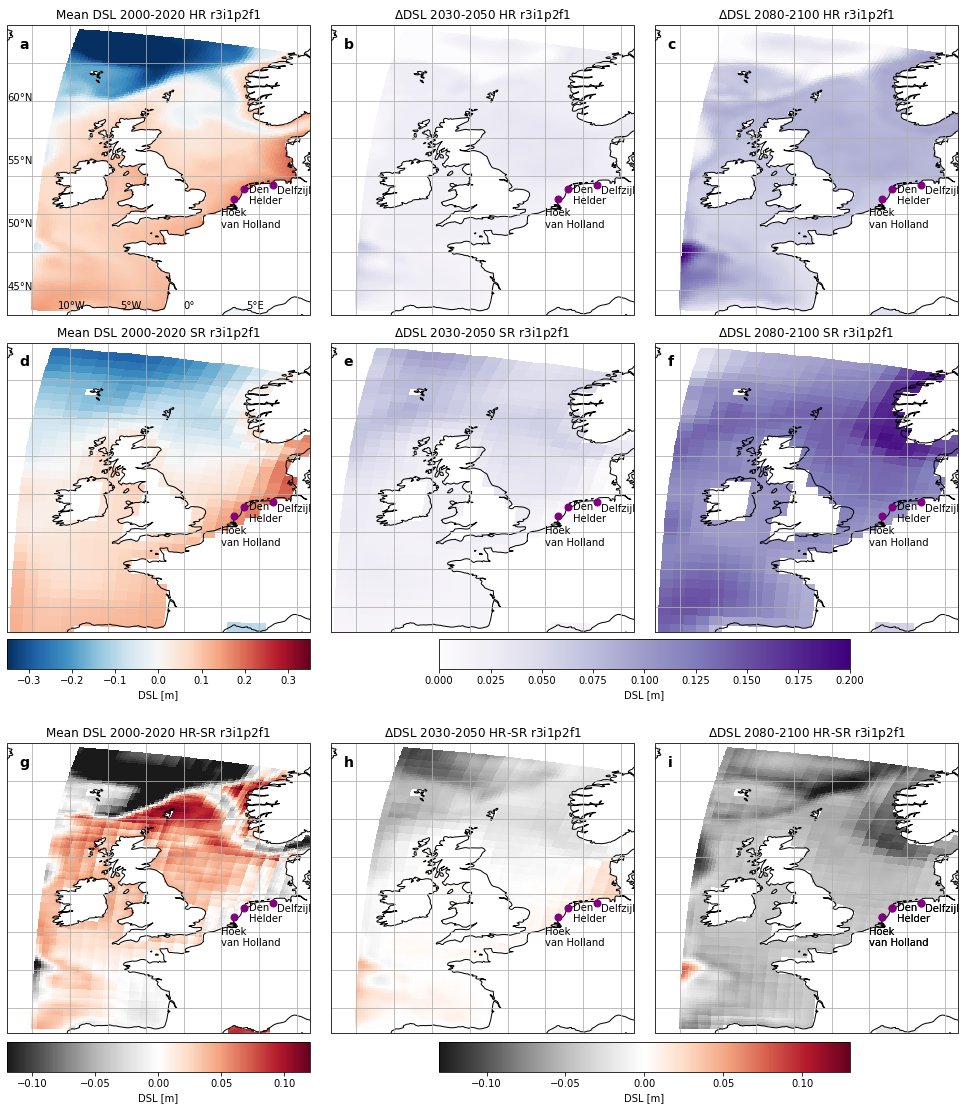

In [17]:
f = plt.figure(figsize=(15,10.5))

for i, res in enumerate(['HR','SR', 'HR-SR']):
    da = xr.open_dataarray(f'../data/zos_NorthSea_{res}.nc')
    if i<2:  # removing global mean from HR and SR; HR-SR is already done above
        da = da - gmzos.sel(src=['EC-Earth3P-HR','EC-Earth3P'][i])
    # member average
    da = da.sel(member='r3i1p2f1')
    # monthly -> yearly
    da = da.groupby(da.time.dt.year).mean()
    # rename longitudes
    da = da.assign_coords(longitude=(((da.longitude + 180) % 360) - 180))
    dhf = da.sel(exp='hist+future')

    # final fields
    hist = dhf.isel({'year':slice( 50, 70)}).mean('year')  # 2000-2020
    midc = dhf.isel({'year':slice( 80,100)}).mean('year')  # 2030-2050
    endc = dhf.isel({'year':slice(130,150)}).mean('year')  # 2080-2100
    
    hist_ = hist - hist.mean()  # 2000-2020
    
    
    for j in range(3):
        # mark Den Helder
       
        delta = r'$\Delta$'

        # we still need to select the mean of a time to show in the map:
        #here first the first maps, which are Mean DSL 90-20 hist+future
        if j==0:
            field = hist_
           
            if i==0:
                title = f'Mean DSL 2000-2020 {res} r3i1p2f1'
                ax = f.add_axes([.1+j*.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                ax.text(-13, 65, 'a', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
                cmap = 'RdBu_r'
                minv, maxv = -.35, .35
                ax.text(0, 43.5, '0°', fontsize=10, transform=ccrs.Geodetic())
                ax.text(5, 43.5, '5°E', fontsize=10, transform=ccrs.Geodetic())
                ax.text(-5, 43.5, '5°W', fontsize=10, transform=ccrs.Geodetic())
                ax.text(-10, 43.5, '10°W', fontsize=10, transform=ccrs.Geodetic())
                ax.text(-14, 60, '60°N', fontsize=10, transform=ccrs.Geodetic())
                ax.text(-14, 55, '55°N', fontsize=10, transform=ccrs.Geodetic())
                ax.text(-14, 50, '50°N', fontsize=10, transform=ccrs.Geodetic())
                ax.text(-14, 45, '45°N', fontsize=10, transform=ccrs.Geodetic())
               
            if i==1:
                title = f'Mean DSL 2000-2020 {res} r3i1p2f1'
                ax = f.add_axes([.1+j*.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                ax.text(-13, 65, 'd', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
                cmap = 'RdBu_r'
                minv, maxv = -.35, .35
                
            if i==2:
                title = f'Mean DSL 2000-2020 {res} r3i1p2f1'
                ax = f.add_axes([.1+j*.3,.55-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdGy_r'
                minv, maxv = -.12, .12
                ax.text(-13, 65, 'g', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            
           
        #then the second, which is the change 2030-2050 with regard to mean DSL 90-20 hist+future
        elif j==1:
            title = f'{delta}DSL 2030-2050 {res} r3i1p2f1'
            field = midc - hist
            
            if i==0:
                ax = f.add_axes([.1+.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .2
                ax.text(-13, 65, 'b', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            if i==1:
                ax = f.add_axes([.1+.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .2
                ax.text(-13, 65, 'e', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            if i==2:
                ax = f.add_axes([.1+.3,.55-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdGy_r'
                minv, maxv = -.13, .13
                ax.text(-13, 65, 'h', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())    
       
        #then the third, which is the change 2080-2100 with regard to mean DSL 90-20 hist+future
        elif j==2:
            title = f'{delta}DSL 2080-2100 {res} r3i1p2f1'
            field = endc - hist
            
            if i==0:
                ax = f.add_axes([.1+j*.3,.58-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .2
                ax.text(-13, 65, 'c', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            elif i==1:
                ax = f.add_axes([.1+j*.3,.58-.42, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'Purples'
                minv, maxv = 0, .2
                ax.text(-13, 65, 'f', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
            elif i==2:
                ax = f.add_axes([.1+j*.3,.55-.46*i, .28, .4], projection=ccrs.PlateCarree())
                cmap = 'RdGy_r'
                minv, maxv = -0.13, .13
                ax.text(-13, 65, 'i', va='top', ha='left', weight='bold', fontsize=14, color='black', transform=ccrs.Geodetic())
                ax.plot(4.7607972, 52.9562808, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
                ax.plot(4, 52.2, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
                ax.plot(7.1,53.33, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
                ax.text(5.2, 51.8, 'Den\nHelder', fontsize=10, transform=ccrs.Geodetic())
                ax.text(3,49.9, 'Hoek\nvan Holland', fontsize=10, transform=ccrs.Geodetic())
                ax.text(7.4, 52.6, 'Delfzijl', fontsize=10, transform=ccrs.Geodetic())
                
        ax.set_extent([-14,10,43,66], crs=ccrs.PlateCarree())
        ax.plot(4.76, 52.95, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
        ax.plot(4, 52.2, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
        ax.plot(7.1,53.33, 'o', markersize=7, color='purple', transform=ccrs.Geodetic())
        ax.text(5.2, 51.8, 'Den\nHelder', fontsize=10, transform=ccrs.Geodetic())
        ax.text(3,49.9, 'Hoek\nvan Holland', fontsize=10, transform=ccrs.Geodetic())
        ax.text(7.4, 52.6, 'Delfzijl', fontsize=10, transform=ccrs.Geodetic())
        im = ax.pcolormesh(da.longitude, da.latitude, 
                            field,
                            vmin=minv, vmax=maxv, cmap=cmap,
                            transform=ccrs.PlateCarree())
        ax.set_title(title)
        ax.coastlines()
        ax.gridlines()
        
        if i==1:
            if j==0:
                cax = f.add_axes([.1+j*.3,0.12,.28,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
            elif j==2:
                cax = f.add_axes([.5,0.12,.38,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
        
        if i==2:
            if j==0:
                cax = f.add_axes([.1+j*.3,-0.413,.28,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
            elif j==2:
                cax = f.add_axes([.5,-0.413,.38,.04])
                plt.colorbar(im, cax=cax, orientation='horizontal', label=r'DSL [m]')
plt.savefig('../results/hist+futzosmap3.jpg', dpi=300, bbox_inches='tight')